### Import

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d
import datetime
from utils import Logger, mkdir_p, progress_bar, save_model, save_args, cal_loss
from collections import defaultdict

import sklearn.metrics as metrics
from data import ModelNet40
from torch.optim.lr_scheduler import CosineAnnealingLR
import sklearn.metrics as metrics
import numpy as np

In [8]:
# degree = 10
# d = 3
# num_poly = math.comb(degree + d, d)
# print('num_poly:', num_poly)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# exponents = []
# # Generate all multi-indices with total degree up to 'degree'
# for total_degree in range(degree + 1):
#     for exps in combinations_with_replacement(range(d), total_degree):
#         exp = torch.zeros(d, dtype=int, device=device)
#         for var in exps:
#             exp[var] += 1
#         exponents.append(exp)
# M = len(exponents)
# print('Number of monomials:', M)
# print('Monomials:', exponents[:10])

# exponents = torch.zeros(num_poly, d, dtype=int, device=device)
# i = 0
# for total_degree in range(degree + 1):
#     for exps in combinations_with_replacement(range(d), total_degree):
#         for var in exps:
#             exponents[i, var] += 1
#         i += 1

# print('Monomials:', exponents[:10])
# print(exponents.shape, exponents.dtype, exponents.device)

In [9]:
from itertools import combinations_with_replacement

def generate_exponents(d, degree):
    """
    Generate all multi-indices with total degree up to 'degree' for d-dimensional points.
    
    Parameters:
        d (int): The dimension of the points.
        degree (int): The maximum degree of the monomials.
    
    Returns:
        ndarray: The multi-indices of shape (num_poly, d).
    """
    num_poly = math.comb(degree + d, d)
    exponents = torch.zeros(num_poly, d, dtype=int)
    i = 0
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            for var in exps:
                exponents[i, var] += 1
            i += 1
            
    return exponents[1:]

def generate_monomials_sequences_batch(X, exponents):
    """
    Generate monomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Monomial sequences of shape (B, M).
    """
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    M = len(exponents)
    # print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    # monomials = torch.ones(B, N, M, device=device)
    # for i, exp in enumerate(exponents):
    #     monomials[:, :, i] = torch.prod(X ** exp, axis=2) # x1^exp1 * x2^exp2 * ... * xd^expd. e.g. x1^2 * x2^3 * x3^1 \in R^3
    monomials = X.unsqueeze(2).repeat(1, 1, M, 1) ** exponents.unsqueeze(0).unsqueeze(0) # (B, N, M, d) ** (1, 1, M, d) -> (B, N, M, d)
    monomials = monomials.prod(dim=-1) # (B, N, M)
    return monomials.sum(dim=1) / N # (B, N, M) -> (B, M)

def generate_chebyshev_polynomials_sequence_batch(X, exponents):
    """
    Generate Chebyshev polynomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Chebyshev polynomial sequences of shape (B, M).
    """
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    cheby_polynomials = torch.cos(exponents.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)) # (B, N, M)
    cheby_polynomials = cheby_polynomials.prod(dim=-1) # (B, N)
    
    return cheby_polynomials.sum(dim=1) / N # (B, N, M) -> (B, M)

def generate_psd_chebyshev_polynomials_sequence_batch(X, exponents):
    """
    Generate Chebyshev polynomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Chebyshev polynomial sequences of shape (B, M).
    """
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    cheby_polynomials = torch.cos((exponents.unsqueeze(0).unsqueeze(0)+0.5) * torch.acos(X).unsqueeze(2)) # (B, N, M)
    cheby_polynomials = cheby_polynomials.prod(dim=-1) # (B, N)
    
    return cheby_polynomials.sum(dim=1) / N # (B, N, M) -> (B, M)

def poly_seq_batch(X, exponents, poly_type='monomial'):
    if poly_type == 'monomial':
        return generate_monomials_sequences_batch(X, exponents)
    elif poly_type == 'chebyshev':
        return generate_chebyshev_polynomials_sequence_batch(X, exponents)
    elif poly_type == 'pseudo_chebyshev':
        return generate_psd_chebyshev_polynomials_sequence_batch(X, exponents)
    else:
        raise ValueError('Unknown polynomial type')

/tmp/ipykernel_4085061/3006960772.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(poly_seq, label = 'class_%d'%label)


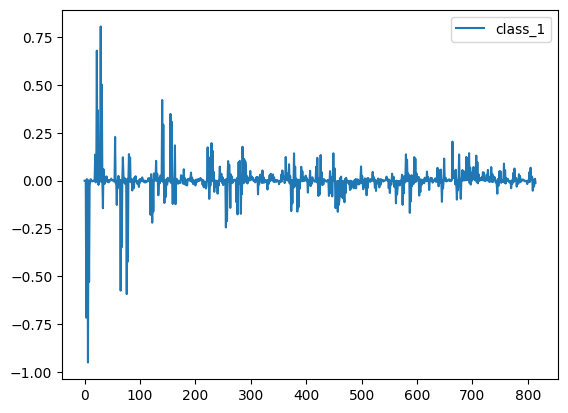

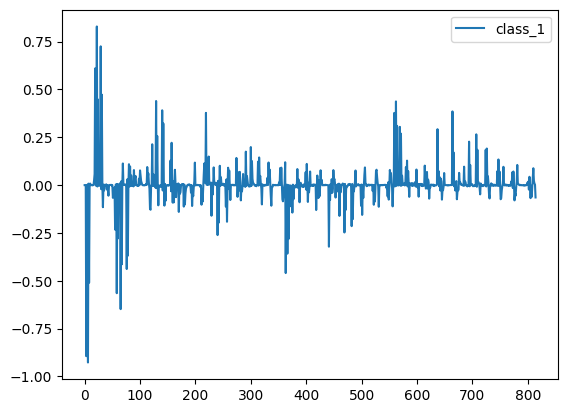

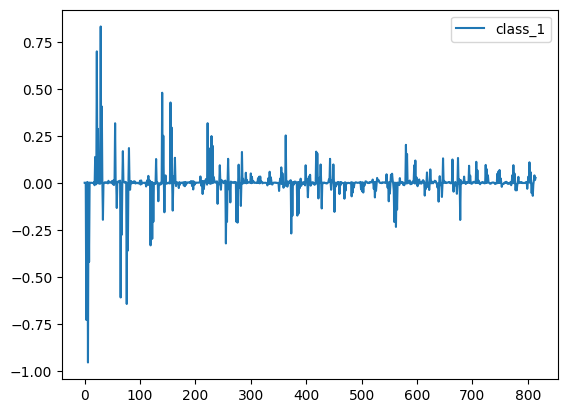

In [10]:
dataset = ModelNet40(partition='train', num_points=1024, aug=False)
exponts = generate_exponents(3, 15)
i=0
shown = 0
while shown < 3:
    data, label = dataset[i]
    i+=1
    if label != 1: 
        continue
    shown += 1
    x = torch.tensor(data).unsqueeze(0)
    poly_seq = poly_seq_batch(x, exponts, 'chebyshev').squeeze(0)
    plt.plot(poly_seq, label = 'class_%d'%label)
    plt.legend()
    plt.show()

/tmp/ipykernel_4085061/2580830185.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(poly_seq, label = 'class_%d'%label)


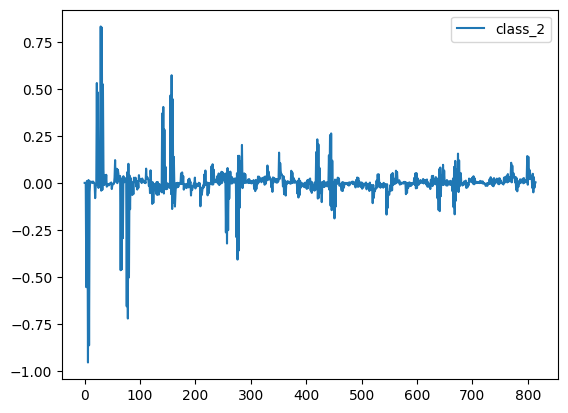

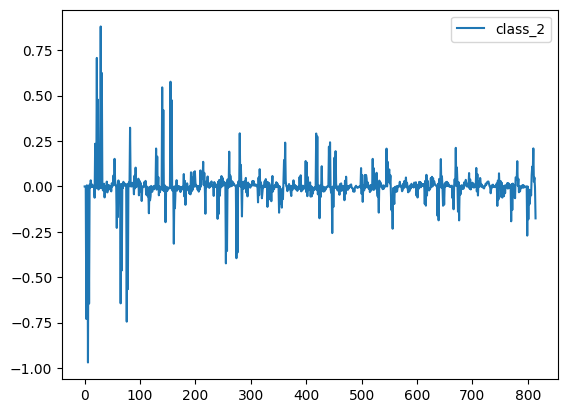

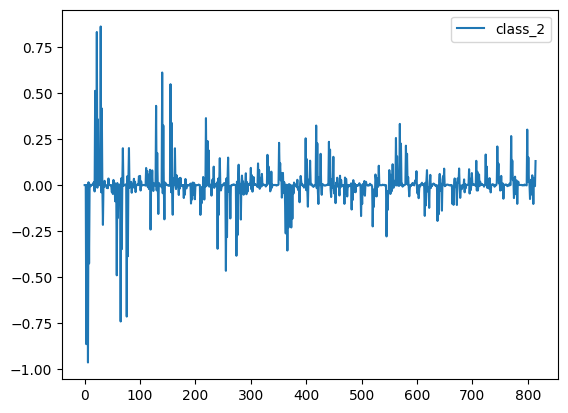

In [11]:
dataset = ModelNet40(partition='train', num_points=1024, aug=False)
exponts = generate_exponents(3, 15)
i=0
shown = 0
while shown < 3:
    data, label = dataset[i]
    i+=1
    if label != 2: 
        continue
    shown += 1
    x = torch.tensor(data).unsqueeze(0)
    poly_seq = poly_seq_batch(x, exponts, 'chebyshev').squeeze(0)
    plt.plot(poly_seq, label = 'class_%d'%label)
    plt.legend()
    plt.show()

/tmp/ipykernel_4085061/2624054136.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(poly_seq, label = 'class_%d'%label)


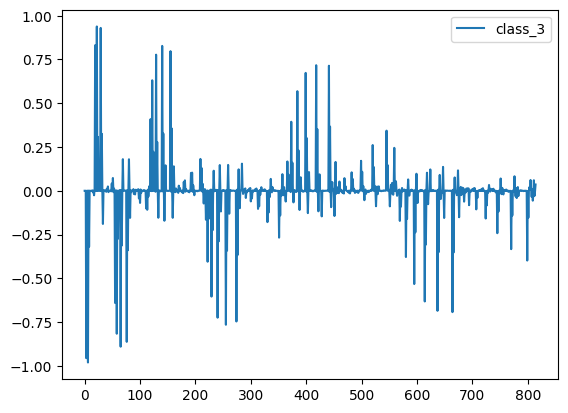

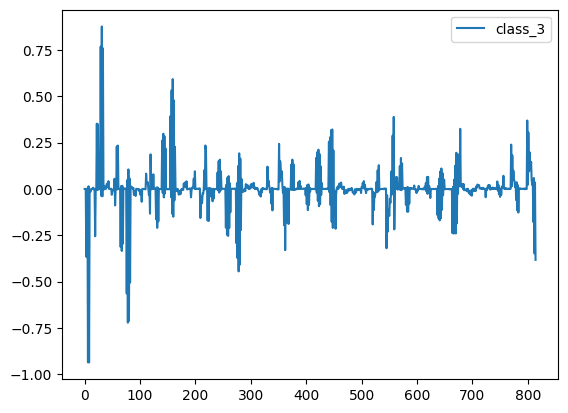

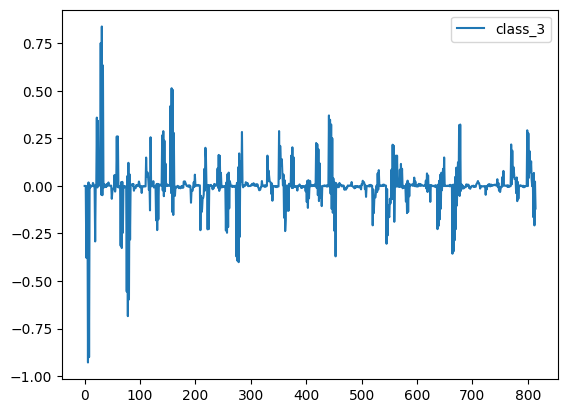

In [12]:
dataset = ModelNet40(partition='train', num_points=1024, aug=False)
exponts = generate_exponents(3, 15)
i=0
shown = 0
while shown < 3:
    data, label = dataset[i]
    i+=1
    if label != 3: 
        continue
    shown += 1
    x = torch.tensor(data).unsqueeze(0)
    poly_seq = poly_seq_batch(x, exponts, 'chebyshev').squeeze(0)
    plt.plot(poly_seq, label = 'class_%d'%label)
    plt.legend()
    plt.show()

/tmp/ipykernel_4085061/2951800703.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(poly_seq, label = 'class_%d'%label)


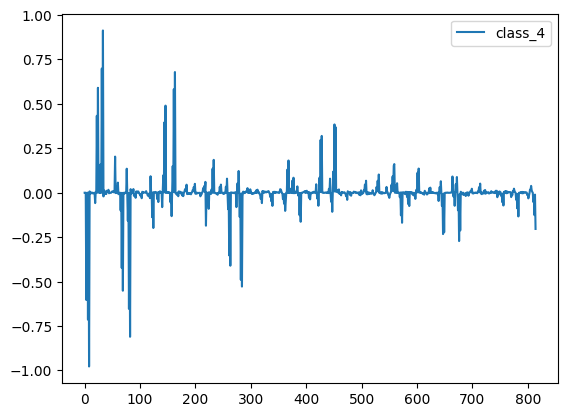

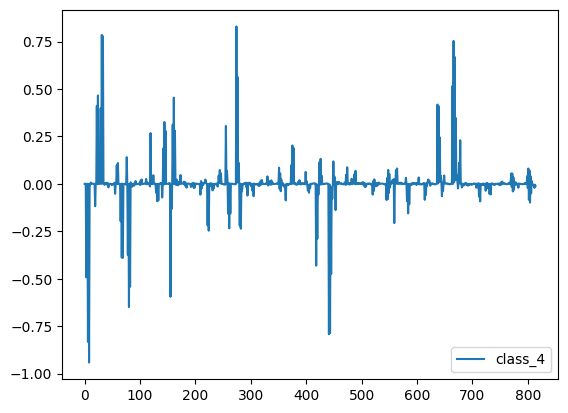

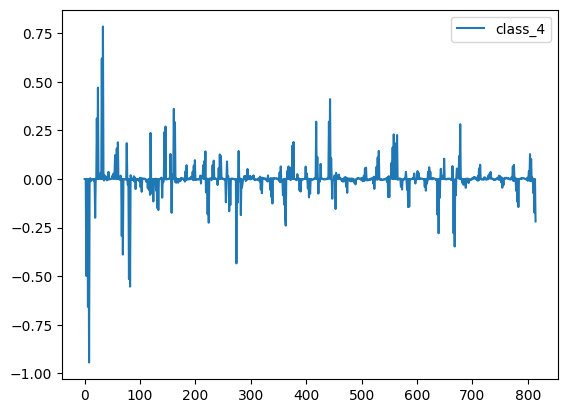

In [13]:
dataset = ModelNet40(partition='train', num_points=1024, aug=False)
exponts = generate_exponents(3, 15)
i=0
shown = 0
while shown < 3:
    data, label = dataset[i]
    i+=1
    if label != 4: 
        continue
    shown += 1
    x = torch.tensor(data).unsqueeze(0)
    poly_seq = poly_seq_batch(x, exponts, 'chebyshev').squeeze(0)
    plt.plot(poly_seq, label = 'class_%d'%label)
    plt.legend()
    plt.show()

In [4]:
# exponents = generate_exponents(d, degree)
# print('exponents:', exponents.shape, exponents[:10])

# X = torch.rand(2, 100, 3)
# polys = generate_chebyshev_polynomials_sequence_batch(X, exponents)
# print('polys:', polys.shape, polys[0, :10])

# polys = generate_chebyshev_polynomials_sequence_batch_old(X, exponents)
# print('polys:', polys.shape, polys[0, :10])

# # time the above functions
# import time

# X = torch.rand(2, 100, 3)
# start = time.time()
# polys = generate_chebyshev_polynomials_sequence_batch(X, exponents)
# print('Time:', time.time() - start)

# start = time.time()
# polys = generate_chebyshev_polynomials_sequence_batch_old(X, exponents)
# print('Time:', time.time() - start)

### Use ModelNet40 as our dataset

In [5]:
class PointNet(nn.Module):
    def __init__(self, d, num_classes):
        super(PointNet, self).__init__()
        self.d = d
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Conv1d(d, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, X):
        B, N, d = X.shape
        X = X.permute(0, 2, 1)
        X = self.encoder(X)
        # print('X:', X.shape)
        X = F.max_pool1d(X, N).squeeze(2)
        X = self.decoder(X)
        return X
    
    def get_loss(self, X, y, loss_type = 'cross_entropy+orthogonality'):
        logits = self(X)
        if loss_type == 'cross_entropy':
            return F.cross_entropy(logits, y)
        elif loss_type == 'cross_entropy+orthogonality':
            B, N, d = X.shape
            N_reg = 1000
            bbox_inputs = torch.FloatTensor(B, N_reg, d).uniform_(-1, 1)
            bbox_inputs = bbox_inputs.to(X.device)
            bbox_inputs = bbox_inputs.permute(0, 2, 1)
            bbox_features = self.encoder(bbox_inputs)
            bbox_matirx = torch.bmm(bbox_features, bbox_features.permute(0, 2, 1)) / N_reg # (B, 1024, 1024)
            I = torch.eye(1024).to(X.device).unsqueeze(0).expand(B, -1, -1)
            orthogonality_loss = F.mse_loss(bbox_matirx, I)
            return F.cross_entropy(logits, y) + orthogonality_loss
        else:
            raise ValueError('Unknown loss type')


### A simple Linear classifier

In [6]:
class MLPClaasifier(nn.Module):
    def __init__(self, dim_in, layer_dims, dim_out, dropout=0.5):
        super(MLPClaasifier, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Sequential(
            nn.Linear(dim_in, layer_dims[0]),
            nn.BatchNorm1d(layer_dims[0]),
            nn.ReLU(),
        ))
        for i in range(1, len(layer_dims)):
            self.convs.append(nn.Sequential(
                nn.Linear(layer_dims[i-1], layer_dims[i]),
                nn.BatchNorm1d(layer_dims[i]),
                nn.Dropout(dropout),
                nn.ReLU(),
            ))
        self.convs.append(nn.Linear(layer_dims[-1], dim_out))

    def forward(self, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x)
        x = self.convs[-1](x)
        return x
    
x = torch.randn(32, 100) # 32 samples, 100 features
model = MLPClaasifier(100, [128, 64], 40)
y = model(x)
print(y.shape)

torch.Size([32, 40])


### A Residual Classifier

In [7]:
class ResNetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, stride=1, dropout=0.5):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Linear(dim_in, dim_out)
        self.bn1 = nn.BatchNorm1d(dim_out)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Linear(dim_out, dim_out)
        self.bn2 = nn.BatchNorm1d(dim_out)
        self.downsample = nn.Sequential()
        if stride != 1 or dim_in != dim_out:
            self.downsample = nn.Sequential(
                nn.Linear(dim_in, dim_out),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNetCls(nn.Module):
    def __init__(self, dim_in, layer_dims, dim_out, dropout=0.5):
        super(ResNetCls, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Sequential(
            nn.Linear(dim_in, layer_dims[0]),
            nn.BatchNorm1d(layer_dims[0]),
            nn.ReLU(),
        ))
        # each block has two conv layers and a skip connection
        for i in range(len(layer_dims)-1):
            self.convs.append(ResNetBlock(layer_dims[i], layer_dims[i+1], dropout=dropout))
        self.convs.append(nn.Linear(layer_dims[-1], dim_out))

    def forward(self, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x)
        x = self.convs[-1](x)
        return x
    
x = torch.randn(32, 100) # 32 samples, 100 features
model = ResNetCls(100, [128, 64], 40)
y = model(x)
print(y.shape)

torch.Size([32, 40])


In [8]:
class MomentNet(nn.Module):
    def __init__(self, dim_in, dim_out, degree, poly_type='chebyshev', cls_type='mlp', layer_dims=None):
        super(MomentNet, self).__init__()
        self.poly_type = poly_type
        self.exponts = generate_exponents(dim_in, degree)
        self.num_poly = len(self.exponts) # number of polynomials. First polynomial is 1, so we exclude it.
        if cls_type == 'linear':
            self.cls = nn.Linear(self.num_poly, dim_out)
        elif cls_type == 'mlp':
            self.cls = MLPClaasifier(self.num_poly, layer_dims, dim_out)
        elif cls_type == 'resnet':
            self.cls = ResNetCls(self.num_poly, layer_dims, dim_out)
        
    def forward(self, x):
        x = poly_seq_batch(x, self.exponts, self.poly_type)
        x = self.cls(x)
        return x
    
    def get_loss(self, x, y, loss_type='cross_entropy'):
        logits = self(x)
        if loss_type == 'cross_entropy':
            return F.cross_entropy(logits, y)
        else:
            raise ValueError('Unknown loss type')
    
x = torch.randn(32, 2048, 3) # 32 samples, 2048 points, 3 features
model = MomentNet(3, 40, 2, poly_type='monomial', layer_dims=[128, 64], cls_type='mlp')
y = model(x)
print(y.shape)

torch.Size([32, 40])


In [9]:
def train(net, trainloader, optimizer, epoch, num_epochs, device, verbose=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_pred = []
    train_true = []
    time_cost = datetime.datetime.now()
    if verbose:
        pbar = tqdm(enumerate(trainloader), total=len(trainloader))
    else:
        pbar = enumerate(trainloader)
    for batch_idx, (data, label) in pbar:
        data, label = data.to(device), label.to(device).squeeze()
        optimizer.zero_grad()
        loss = net.get_loss(data, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        logits = net(data)
        train_loss += loss.item()
        preds = logits.max(dim=1)[1]

        train_true.append(label.cpu().numpy())
        train_pred.append(preds.detach().cpu().numpy())

        total += label.size(0)
        correct += preds.eq(label).sum().item()

        if verbose:
            pbar.set_description(f'({epoch:3d}/{num_epochs:3d}) Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100. * correct / total:.3f}% ({correct}/{total})')
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    time_cost = int((datetime.datetime.now() - time_cost).total_seconds())
    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    return {
        "loss": float("%.3f" % (train_loss / (batch_idx + 1))),
        "acc": float("%.3f" % (100. * metrics.accuracy_score(train_true, train_pred))),
        "acc_avg": float("%.3f" % (100. * metrics.balanced_accuracy_score(train_true, train_pred))),
        "time": time_cost
    }


def validate(net, testloader, epoch, num_epochs, device, verbose=True):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_true = []
    test_pred = []
    time_cost = datetime.datetime.now()
    with torch.no_grad():
        if verbose:
            pbar = tqdm(enumerate(testloader), total=len(testloader))
        else:
            pbar = enumerate(testloader)
        for batch_idx, (data, label) in pbar:
            data, label = data.to(device), label.to(device).squeeze()
            logits = net(data)
            loss = net.get_loss(data, label)
            test_loss += loss.item()
            preds = logits.max(dim=1)[1]
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
            total += label.size(0)
            correct += preds.eq(label).sum().item()
            if verbose:
                pbar.set_description(f'({epoch:3d}/{num_epochs:3d}) Loss: {test_loss / (batch_idx + 1):.3f} | Acc: {100. * correct / total:.3f}% ({correct}/{total})')
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    time_cost = int((datetime.datetime.now() - time_cost).total_seconds())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    return {
        "loss": float("%.3f" % (test_loss / (batch_idx + 1))),
        "acc": float("%.3f" % (100. * metrics.accuracy_score(test_true, test_pred))),
        "acc_avg": float("%.3f" % (100. * metrics.balanced_accuracy_score(test_true, test_pred))),
        "time": time_cost
    }

In [10]:
# Training (Taken from PointMLP-PyTorch)
def run_experiment(num_epochs = 50, # Number of epochs
                   max_lr = 0.1, # Maximum learning rate
                   min_lr = 0.001, # Minimum learning rate
                   degree = 10, # Degree of the polynomials
                   poly_type = 'chebyshev', # Type of polynomials
                   cls_type = 'mlp', # Type of classifier ['mlp', 'linear']                    
                   layer_dims = [512, 256, 128], # Layer dimensions for the classifier (MLP)
                   num_points = 1024,
                   batch_size = 32,
                   verbose = False
                   ): 

    train_loader = DataLoader(ModelNet40(partition='train', 
                                            num_points=num_points,
                                            aug=False), 
                                num_workers=8,
                                batch_size=batch_size, 
                                shuffle=True, 
                                drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', 
                                            num_points=num_points,
                                            aug=False), 
                                num_workers=8,
                                batch_size=batch_size // 2, 
                                shuffle=False, 
                                drop_last=False)
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    best_test_acc = 0.  # best test accuracy
    best_train_acc = 0.
    best_test_acc_avg = 0.
    best_train_acc_avg = 0.
    best_test_loss = float("inf")
    best_train_loss = float("inf")
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    # Model
    net = MomentNet(3, 40, degree = degree, poly_type = poly_type, cls_type=cls_type, layer_dims=layer_dims).to(device)

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=max_lr, momentum=0.9, weight_decay=0)
    scheduler = CosineAnnealingLR(optimizer, num_epochs, eta_min=min_lr, last_epoch=start_epoch - 1)

    for epoch in range(start_epoch, num_epochs):
        train_out = train(net, train_loader, optimizer, epoch, num_epochs, device, verbose)  # {"loss", "acc", "acc_avg", "time"}
        test_out = validate(net, test_loader, epoch, num_epochs, device, verbose)
        scheduler.step()
        if test_out["acc"] > best_test_acc:
            best_test_acc = test_out["acc"]
            is_best = True
        else:
            is_best = False

        best_test_acc = test_out["acc"] if (test_out["acc"] > best_test_acc) else best_test_acc
        best_train_acc = train_out["acc"] if (train_out["acc"] > best_train_acc) else best_train_acc
        best_test_acc_avg = test_out["acc_avg"] if (test_out["acc_avg"] > best_test_acc_avg) else best_test_acc_avg
        best_train_acc_avg = train_out["acc_avg"] if (train_out["acc_avg"] > best_train_acc_avg) else best_train_acc_avg
        best_test_loss = test_out["loss"] if (test_out["loss"] < best_test_loss) else best_test_loss
        best_train_loss = train_out["loss"] if (train_out["loss"] < best_train_loss) else best_train_loss

        if verbose:
            print(
            f"Training loss:{train_out['loss']} acc_avg:{train_out['acc_avg']}% acc:{train_out['acc']}% time:{train_out['time']}s")
            print(
            f"Testing loss:{test_out['loss']} acc_avg:{test_out['acc_avg']}% "
            f"acc:{test_out['acc']}% time:{test_out['time']}s [best test acc: {best_test_acc}%]")

    return {
        "best_test_acc": best_test_acc,
        "best_train_acc": best_train_acc,
        "best_test_acc_avg": best_test_acc_avg,
        "best_train_acc_avg": best_train_acc_avg,
        "best_test_loss": best_test_loss,
        "best_train_loss": best_train_loss
    }
    

In [11]:
# Training (Taken from PointMLP-PyTorch)
def run_experiment_pointnet(num_epochs = 50, # Number of epochs
                   max_lr = 0.1, # Maximum learning rate
                   min_lr = 0.001, # Minimum learning rate
                   num_points = 1024,
                   batch_size = 32,
                   verbose = False
                   ): 

    train_loader = DataLoader(ModelNet40(partition='train', 
                                            num_points=num_points,
                                            aug=False), 
                                num_workers=8,
                                batch_size=batch_size, 
                                shuffle=True, 
                                drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', 
                                            num_points=num_points,
                                            aug=False), 
                                num_workers=8,
                                batch_size=batch_size // 2, 
                                shuffle=False, 
                                drop_last=False)
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    best_test_acc = 0.  # best test accuracy
    best_train_acc = 0.
    best_test_acc_avg = 0.
    best_train_acc_avg = 0.
    best_test_loss = float("inf")
    best_train_loss = float("inf")
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    # Model
    net = PointNet(3, 40).to(device)

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=max_lr, momentum=0.9, weight_decay=0)
    scheduler = CosineAnnealingLR(optimizer, num_epochs, eta_min=min_lr, last_epoch=start_epoch - 1)

    for epoch in range(start_epoch, num_epochs):
        train_out = train(net, train_loader, optimizer, epoch, num_epochs, device, verbose)  # {"loss", "acc", "acc_avg", "time"}
        test_out = validate(net, test_loader, epoch, num_epochs, device, verbose)
        scheduler.step()
        if test_out["acc"] > best_test_acc:
            best_test_acc = test_out["acc"]
            is_best = True
        else:
            is_best = False

        best_test_acc = test_out["acc"] if (test_out["acc"] > best_test_acc) else best_test_acc
        best_train_acc = train_out["acc"] if (train_out["acc"] > best_train_acc) else best_train_acc
        best_test_acc_avg = test_out["acc_avg"] if (test_out["acc_avg"] > best_test_acc_avg) else best_test_acc_avg
        best_train_acc_avg = train_out["acc_avg"] if (train_out["acc_avg"] > best_train_acc_avg) else best_train_acc_avg
        best_test_loss = test_out["loss"] if (test_out["loss"] < best_test_loss) else best_test_loss
        best_train_loss = train_out["loss"] if (train_out["loss"] < best_train_loss) else best_train_loss

        if verbose:
            print(
            f"Training loss:{train_out['loss']} acc_avg:{train_out['acc_avg']}% acc:{train_out['acc']}% time:{train_out['time']}s")
            print(
            f"Testing loss:{test_out['loss']} acc_avg:{test_out['acc_avg']}% "
            f"acc:{test_out['acc']}% time:{test_out['time']}s [best test acc: {best_test_acc}%]")

    return {
        "best_test_acc": best_test_acc,
        "best_train_acc": best_train_acc,
        "best_test_acc_avg": best_test_acc_avg,
        "best_train_acc_avg": best_train_acc_avg,
        "best_test_loss": best_test_loss,
        "best_train_loss": best_train_loss
    }
    

In [12]:
run_experiment_pointnet(num_epochs = 50, # Number of epochs
                     max_lr = 0.1, # Maximum learning rate
                     min_lr = 0.001, # Minimum learning rate
                     num_points = 1024,
                     batch_size = 32,
                     verbose = True
                     )

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
run_experiment(num_epochs = 50, # Number of epochs
                   max_lr = 0.1, # Maximum learning rate
                   min_lr = 0.001, # Minimum learning rate
                   degree = 15, # Degree of the polynomials
                   poly_type = 'chebyshev', # Type of polynomials
                   cls_type = 'mlp', # Type of classifier ['mlp', 'linear']                    
                   layer_dims = [512, 256, 128], # Layer dimensions for the classifier (MLP)
                   num_points = 1024,
                   batch_size = 32,
                   verbose = True
                   )

(  0/ 50) Loss: 1.811 | Acc: 51.965% (5105/9824): 100%|██████████| 307/307 [00:01<00:00, 173.54it/s]
(  0/ 50) Loss: 1.173 | Acc: 66.126% (1632/2468): 100%|██████████| 155/155 [00:00<00:00, 400.75it/s]


Training loss:1.811 acc_avg:34.05% acc:51.965% time:2s
Testing loss:1.173 acc_avg:52.837% acc:66.126% time:0s [best test acc: 66.126%]


(  1/ 50) Loss: 1.281 | Acc: 64.251% (6312/9824): 100%|██████████| 307/307 [00:01<00:00, 274.46it/s]
(  1/ 50) Loss: 0.900 | Acc: 73.622% (1817/2468): 100%|██████████| 155/155 [00:00<00:00, 408.90it/s]


Training loss:1.281 acc_avg:49.072% acc:64.251% time:1s
Testing loss:0.9 acc_avg:61.094% acc:73.622% time:0s [best test acc: 73.622%]


(  2/ 50) Loss: 1.130 | Acc: 67.539% (6635/9824): 100%|██████████| 307/307 [00:01<00:00, 255.30it/s]
(  2/ 50) Loss: 0.830 | Acc: 75.567% (1865/2468): 100%|██████████| 155/155 [00:00<00:00, 394.37it/s]


Training loss:1.13 acc_avg:53.875% acc:67.539% time:1s
Testing loss:0.83 acc_avg:63.47% acc:75.567% time:0s [best test acc: 75.567%]


(  3/ 50) Loss: 1.044 | Acc: 70.531% (6929/9824): 100%|██████████| 307/307 [00:01<00:00, 255.77it/s]
(  3/ 50) Loss: 0.832 | Acc: 76.985% (1900/2468): 100%|██████████| 155/155 [00:00<00:00, 381.52it/s]


Training loss:1.044 acc_avg:57.894% acc:70.531% time:1s
Testing loss:0.832 acc_avg:65.93% acc:76.985% time:0s [best test acc: 76.985%]


(  4/ 50) Loss: 0.960 | Acc: 72.089% (7082/9824): 100%|██████████| 307/307 [00:01<00:00, 280.33it/s]
(  4/ 50) Loss: 0.757 | Acc: 78.890% (1947/2468): 100%|██████████| 155/155 [00:00<00:00, 376.39it/s]


Training loss:0.96 acc_avg:59.932% acc:72.089% time:1s
Testing loss:0.757 acc_avg:68.846% acc:78.89% time:0s [best test acc: 78.89%]


(  5/ 50) Loss: 0.926 | Acc: 73.259% (7197/9824): 100%|██████████| 307/307 [00:01<00:00, 276.28it/s]
(  5/ 50) Loss: 0.750 | Acc: 78.525% (1938/2468): 100%|██████████| 155/155 [00:00<00:00, 388.16it/s]


Training loss:0.926 acc_avg:61.387% acc:73.259% time:1s
Testing loss:0.75 acc_avg:68.588% acc:78.525% time:0s [best test acc: 78.89%]


(  6/ 50) Loss: 0.881 | Acc: 74.613% (7330/9824): 100%|██████████| 307/307 [00:01<00:00, 253.93it/s]
(  6/ 50) Loss: 0.729 | Acc: 78.971% (1949/2468): 100%|██████████| 155/155 [00:00<00:00, 417.27it/s]


Training loss:0.881 acc_avg:63.437% acc:74.613% time:1s
Testing loss:0.729 acc_avg:69.441% acc:78.971% time:0s [best test acc: 78.971%]


(  7/ 50) Loss: 0.833 | Acc: 75.753% (7442/9824): 100%|██████████| 307/307 [00:01<00:00, 282.59it/s]
(  7/ 50) Loss: 0.657 | Acc: 81.564% (2013/2468): 100%|██████████| 155/155 [00:00<00:00, 375.02it/s]


Training loss:0.833 acc_avg:64.982% acc:75.753% time:1s
Testing loss:0.657 acc_avg:71.291% acc:81.564% time:0s [best test acc: 81.564%]


(  8/ 50) Loss: 0.812 | Acc: 76.904% (7555/9824): 100%|██████████| 307/307 [00:01<00:00, 278.59it/s]
(  8/ 50) Loss: 0.650 | Acc: 81.280% (2006/2468): 100%|██████████| 155/155 [00:00<00:00, 393.08it/s]


Training loss:0.812 acc_avg:66.795% acc:76.904% time:1s
Testing loss:0.65 acc_avg:71.286% acc:81.28% time:0s [best test acc: 81.564%]


(  9/ 50) Loss: 0.779 | Acc: 77.555% (7619/9824): 100%|██████████| 307/307 [00:01<00:00, 267.55it/s]
(  9/ 50) Loss: 0.630 | Acc: 82.253% (2030/2468): 100%|██████████| 155/155 [00:00<00:00, 402.75it/s]


Training loss:0.779 acc_avg:67.153% acc:77.555% time:1s
Testing loss:0.63 acc_avg:72.724% acc:82.253% time:0s [best test acc: 82.253%]


( 10/ 50) Loss: 0.760 | Acc: 77.687% (7632/9824): 100%|██████████| 307/307 [00:01<00:00, 279.86it/s]
( 10/ 50) Loss: 0.628 | Acc: 82.496% (2036/2468): 100%|██████████| 155/155 [00:00<00:00, 414.24it/s]


Training loss:0.76 acc_avg:67.374% acc:77.687% time:1s
Testing loss:0.628 acc_avg:73.102% acc:82.496% time:0s [best test acc: 82.496%]


( 11/ 50) Loss: 0.730 | Acc: 78.624% (7724/9824): 100%|██████████| 307/307 [00:01<00:00, 250.66it/s]
( 11/ 50) Loss: 0.646 | Acc: 82.415% (2034/2468): 100%|██████████| 155/155 [00:00<00:00, 383.26it/s]


Training loss:0.73 acc_avg:69.001% acc:78.624% time:1s
Testing loss:0.646 acc_avg:74.669% acc:82.415% time:0s [best test acc: 82.496%]


( 12/ 50) Loss: 0.711 | Acc: 78.736% (7735/9824): 100%|██████████| 307/307 [00:01<00:00, 276.49it/s]
( 12/ 50) Loss: 0.595 | Acc: 83.590% (2063/2468): 100%|██████████| 155/155 [00:00<00:00, 387.38it/s]


Training loss:0.711 acc_avg:69.133% acc:78.736% time:1s
Testing loss:0.595 acc_avg:73.873% acc:83.59% time:0s [best test acc: 83.59%]


( 13/ 50) Loss: 0.690 | Acc: 79.764% (7836/9824): 100%|██████████| 307/307 [00:01<00:00, 241.17it/s]
( 13/ 50) Loss: 0.587 | Acc: 83.752% (2067/2468): 100%|██████████| 155/155 [00:00<00:00, 416.37it/s]


Training loss:0.69 acc_avg:70.195% acc:79.764% time:1s
Testing loss:0.587 acc_avg:75.34% acc:83.752% time:0s [best test acc: 83.752%]


( 14/ 50) Loss: 0.661 | Acc: 80.263% (7885/9824): 100%|██████████| 307/307 [00:01<00:00, 274.73it/s]
( 14/ 50) Loss: 0.596 | Acc: 82.942% (2047/2468): 100%|██████████| 155/155 [00:00<00:00, 391.20it/s]


Training loss:0.661 acc_avg:71.458% acc:80.263% time:1s
Testing loss:0.596 acc_avg:74.773% acc:82.942% time:0s [best test acc: 83.752%]


( 15/ 50) Loss: 0.661 | Acc: 80.843% (7942/9824): 100%|██████████| 307/307 [00:01<00:00, 253.21it/s]
( 15/ 50) Loss: 0.549 | Acc: 85.089% (2100/2468): 100%|██████████| 155/155 [00:00<00:00, 420.87it/s]


Training loss:0.661 acc_avg:72.48% acc:80.843% time:1s
Testing loss:0.549 acc_avg:76.493% acc:85.089% time:0s [best test acc: 85.089%]


( 16/ 50) Loss: 0.646 | Acc: 81.281% (7985/9824): 100%|██████████| 307/307 [00:01<00:00, 268.83it/s]
( 16/ 50) Loss: 0.575 | Acc: 83.347% (2057/2468): 100%|██████████| 155/155 [00:00<00:00, 409.18it/s]


Training loss:0.646 acc_avg:72.799% acc:81.281% time:1s
Testing loss:0.575 acc_avg:76.095% acc:83.347% time:0s [best test acc: 85.089%]


( 17/ 50) Loss: 0.627 | Acc: 81.698% (8026/9824): 100%|██████████| 307/307 [00:01<00:00, 278.22it/s]
( 17/ 50) Loss: 0.585 | Acc: 84.036% (2074/2468): 100%|██████████| 155/155 [00:00<00:00, 404.32it/s]


Training loss:0.627 acc_avg:73.058% acc:81.698% time:1s
Testing loss:0.585 acc_avg:75.885% acc:84.036% time:0s [best test acc: 85.089%]


( 18/ 50) Loss: 0.590 | Acc: 82.319% (8087/9824): 100%|██████████| 307/307 [00:01<00:00, 287.60it/s]
( 18/ 50) Loss: 0.583 | Acc: 84.238% (2079/2468): 100%|██████████| 155/155 [00:00<00:00, 393.87it/s]


Training loss:0.59 acc_avg:74.198% acc:82.319% time:1s
Testing loss:0.583 acc_avg:76.897% acc:84.238% time:0s [best test acc: 85.089%]


( 19/ 50) Loss: 0.579 | Acc: 82.797% (8134/9824): 100%|██████████| 307/307 [00:01<00:00, 261.53it/s]
( 19/ 50) Loss: 0.600 | Acc: 84.117% (2076/2468): 100%|██████████| 155/155 [00:00<00:00, 407.31it/s]


Training loss:0.579 acc_avg:74.43% acc:82.797% time:1s
Testing loss:0.6 acc_avg:77.147% acc:84.117% time:0s [best test acc: 85.089%]


( 20/ 50) Loss: 0.568 | Acc: 83.174% (8171/9824): 100%|██████████| 307/307 [00:01<00:00, 247.03it/s]
( 20/ 50) Loss: 0.552 | Acc: 84.441% (2084/2468): 100%|██████████| 155/155 [00:00<00:00, 420.91it/s]


Training loss:0.568 acc_avg:75.298% acc:83.174% time:1s
Testing loss:0.552 acc_avg:76.582% acc:84.441% time:0s [best test acc: 85.089%]


( 21/ 50) Loss: 0.556 | Acc: 83.561% (8209/9824): 100%|██████████| 307/307 [00:01<00:00, 248.04it/s]
( 21/ 50) Loss: 0.561 | Acc: 84.846% (2094/2468): 100%|██████████| 155/155 [00:00<00:00, 363.29it/s]


Training loss:0.556 acc_avg:76.088% acc:83.561% time:1s
Testing loss:0.561 acc_avg:78.114% acc:84.846% time:0s [best test acc: 85.089%]


( 22/ 50) Loss: 0.542 | Acc: 83.998% (8252/9824): 100%|██████████| 307/307 [00:01<00:00, 275.13it/s]
( 22/ 50) Loss: 0.559 | Acc: 85.049% (2099/2468): 100%|██████████| 155/155 [00:00<00:00, 398.07it/s]


Training loss:0.542 acc_avg:76.881% acc:83.998% time:1s
Testing loss:0.559 acc_avg:78.231% acc:85.049% time:0s [best test acc: 85.089%]


( 23/ 50) Loss: 0.520 | Acc: 84.009% (8253/9824): 100%|██████████| 307/307 [00:01<00:00, 266.96it/s]
( 23/ 50) Loss: 0.551 | Acc: 84.887% (2095/2468): 100%|██████████| 155/155 [00:00<00:00, 388.76it/s]


Training loss:0.52 acc_avg:76.833% acc:84.009% time:1s
Testing loss:0.551 acc_avg:77.598% acc:84.887% time:0s [best test acc: 85.089%]


( 24/ 50) Loss: 0.496 | Acc: 84.629% (8314/9824): 100%|██████████| 307/307 [00:01<00:00, 280.16it/s]
( 24/ 50) Loss: 0.565 | Acc: 84.724% (2091/2468): 100%|██████████| 155/155 [00:00<00:00, 371.81it/s]


Training loss:0.496 acc_avg:77.43% acc:84.629% time:1s
Testing loss:0.565 acc_avg:76.848% acc:84.724% time:0s [best test acc: 85.089%]


( 25/ 50) Loss: 0.491 | Acc: 84.986% (8349/9824): 100%|██████████| 307/307 [00:01<00:00, 265.97it/s]
( 25/ 50) Loss: 0.561 | Acc: 85.413% (2108/2468): 100%|██████████| 155/155 [00:00<00:00, 420.91it/s]


Training loss:0.491 acc_avg:77.733% acc:84.986% time:1s
Testing loss:0.561 acc_avg:79.522% acc:85.413% time:0s [best test acc: 85.413%]


( 26/ 50) Loss: 0.450 | Acc: 86.055% (8454/9824): 100%|██████████| 307/307 [00:01<00:00, 256.47it/s]
( 26/ 50) Loss: 0.568 | Acc: 85.373% (2107/2468): 100%|██████████| 155/155 [00:00<00:00, 395.95it/s]


Training loss:0.45 acc_avg:79.417% acc:86.055% time:1s
Testing loss:0.568 acc_avg:79.11% acc:85.373% time:0s [best test acc: 85.413%]


( 27/ 50) Loss: 0.469 | Acc: 85.515% (8401/9824): 100%|██████████| 307/307 [00:01<00:00, 282.32it/s]
( 27/ 50) Loss: 0.576 | Acc: 84.117% (2076/2468): 100%|██████████| 155/155 [00:00<00:00, 399.03it/s]


Training loss:0.469 acc_avg:78.556% acc:85.515% time:1s
Testing loss:0.576 acc_avg:77.523% acc:84.117% time:0s [best test acc: 85.413%]


( 28/ 50) Loss: 0.456 | Acc: 85.983% (8447/9824): 100%|██████████| 307/307 [00:01<00:00, 276.48it/s]
( 28/ 50) Loss: 0.529 | Acc: 85.697% (2115/2468): 100%|██████████| 155/155 [00:00<00:00, 404.04it/s]


Training loss:0.456 acc_avg:79.448% acc:85.983% time:1s
Testing loss:0.529 acc_avg:78.914% acc:85.697% time:0s [best test acc: 85.697%]


( 29/ 50) Loss: 0.441 | Acc: 86.299% (8478/9824): 100%|██████████| 307/307 [00:01<00:00, 288.23it/s]
( 29/ 50) Loss: 0.560 | Acc: 85.049% (2099/2468): 100%|██████████| 155/155 [00:00<00:00, 385.00it/s]


Training loss:0.441 acc_avg:79.736% acc:86.299% time:1s
Testing loss:0.56 acc_avg:78.414% acc:85.049% time:0s [best test acc: 85.697%]


( 30/ 50) Loss: 0.425 | Acc: 86.808% (8528/9824): 100%|██████████| 307/307 [00:01<00:00, 287.27it/s]
( 30/ 50) Loss: 0.523 | Acc: 86.224% (2128/2468): 100%|██████████| 155/155 [00:00<00:00, 387.67it/s]


Training loss:0.425 acc_avg:80.623% acc:86.808% time:1s
Testing loss:0.523 acc_avg:80.202% acc:86.224% time:0s [best test acc: 86.224%]


( 31/ 50) Loss: 0.426 | Acc: 87.164% (8563/9824): 100%|██████████| 307/307 [00:01<00:00, 279.73it/s]
( 31/ 50) Loss: 0.538 | Acc: 86.345% (2131/2468): 100%|██████████| 155/155 [00:00<00:00, 392.95it/s]


Training loss:0.426 acc_avg:80.716% acc:87.164% time:1s
Testing loss:0.538 acc_avg:80.231% acc:86.345% time:0s [best test acc: 86.345%]


( 32/ 50) Loss: 0.395 | Acc: 87.846% (8630/9824): 100%|██████████| 307/307 [00:01<00:00, 284.02it/s]
( 32/ 50) Loss: 0.540 | Acc: 86.629% (2138/2468): 100%|██████████| 155/155 [00:00<00:00, 372.72it/s]


Training loss:0.395 acc_avg:82.103% acc:87.846% time:1s
Testing loss:0.54 acc_avg:80.568% acc:86.629% time:0s [best test acc: 86.629%]


( 33/ 50) Loss: 0.391 | Acc: 87.541% (8600/9824): 100%|██████████| 307/307 [00:01<00:00, 282.06it/s]
( 33/ 50) Loss: 0.536 | Acc: 86.305% (2130/2468): 100%|██████████| 155/155 [00:00<00:00, 419.62it/s]


Training loss:0.391 acc_avg:81.783% acc:87.541% time:1s
Testing loss:0.536 acc_avg:80.531% acc:86.305% time:0s [best test acc: 86.629%]


( 34/ 50) Loss: 0.375 | Acc: 87.978% (8643/9824): 100%|██████████| 307/307 [00:01<00:00, 284.30it/s]
( 34/ 50) Loss: 0.537 | Acc: 86.386% (2132/2468): 100%|██████████| 155/155 [00:00<00:00, 410.48it/s]


Training loss:0.375 acc_avg:82.131% acc:87.978% time:1s
Testing loss:0.537 acc_avg:80.194% acc:86.386% time:0s [best test acc: 86.629%]


( 35/ 50) Loss: 0.369 | Acc: 88.375% (8682/9824): 100%|██████████| 307/307 [00:01<00:00, 287.84it/s]
( 35/ 50) Loss: 0.538 | Acc: 86.345% (2131/2468): 100%|██████████| 155/155 [00:00<00:00, 396.74it/s]


Training loss:0.369 acc_avg:82.571% acc:88.375% time:1s
Testing loss:0.538 acc_avg:80.448% acc:86.345% time:0s [best test acc: 86.629%]


( 36/ 50) Loss: 0.358 | Acc: 88.762% (8720/9824): 100%|██████████| 307/307 [00:01<00:00, 280.42it/s]
( 36/ 50) Loss: 0.538 | Acc: 86.669% (2139/2468): 100%|██████████| 155/155 [00:00<00:00, 406.58it/s]


Training loss:0.358 acc_avg:83.432% acc:88.762% time:1s
Testing loss:0.538 acc_avg:80.439% acc:86.669% time:0s [best test acc: 86.669%]


( 37/ 50) Loss: 0.358 | Acc: 88.823% (8726/9824): 100%|██████████| 307/307 [00:01<00:00, 278.48it/s]
( 37/ 50) Loss: 0.556 | Acc: 86.386% (2132/2468): 100%|██████████| 155/155 [00:00<00:00, 378.09it/s]


Training loss:0.358 acc_avg:83.481% acc:88.823% time:1s
Testing loss:0.556 acc_avg:80.201% acc:86.386% time:0s [best test acc: 86.669%]


( 38/ 50) Loss: 0.331 | Acc: 89.515% (8794/9824): 100%|██████████| 307/307 [00:01<00:00, 253.33it/s]
( 38/ 50) Loss: 0.550 | Acc: 86.467% (2134/2468): 100%|██████████| 155/155 [00:00<00:00, 369.06it/s]


Training loss:0.331 acc_avg:84.276% acc:89.515% time:1s
Testing loss:0.55 acc_avg:81.031% acc:86.467% time:0s [best test acc: 86.669%]


( 39/ 50) Loss: 0.333 | Acc: 89.373% (8780/9824): 100%|██████████| 307/307 [00:01<00:00, 263.94it/s]
( 39/ 50) Loss: 0.552 | Acc: 86.831% (2143/2468): 100%|██████████| 155/155 [00:00<00:00, 377.64it/s]


Training loss:0.333 acc_avg:84.481% acc:89.373% time:1s
Testing loss:0.552 acc_avg:80.776% acc:86.831% time:0s [best test acc: 86.831%]


( 40/ 50) Loss: 0.324 | Acc: 89.739% (8816/9824): 100%|██████████| 307/307 [00:01<00:00, 284.84it/s]
( 40/ 50) Loss: 0.531 | Acc: 87.196% (2152/2468): 100%|██████████| 155/155 [00:00<00:00, 410.21it/s]


Training loss:0.324 acc_avg:84.514% acc:89.739% time:1s
Testing loss:0.531 acc_avg:81.363% acc:87.196% time:0s [best test acc: 87.196%]


( 41/ 50) Loss: 0.332 | Acc: 89.241% (8767/9824): 100%|██████████| 307/307 [00:01<00:00, 262.45it/s]
( 41/ 50) Loss: 0.537 | Acc: 86.791% (2142/2468): 100%|██████████| 155/155 [00:00<00:00, 379.42it/s]


Training loss:0.332 acc_avg:83.836% acc:89.241% time:1s
Testing loss:0.537 acc_avg:80.372% acc:86.791% time:0s [best test acc: 87.196%]


( 42/ 50) Loss: 0.321 | Acc: 89.627% (8805/9824): 100%|██████████| 307/307 [00:01<00:00, 280.34it/s]
( 42/ 50) Loss: 0.550 | Acc: 86.669% (2139/2468): 100%|██████████| 155/155 [00:00<00:00, 396.95it/s]


Training loss:0.321 acc_avg:84.254% acc:89.627% time:1s
Testing loss:0.55 acc_avg:81.319% acc:86.669% time:0s [best test acc: 87.196%]


( 43/ 50) Loss: 0.312 | Acc: 89.953% (8837/9824): 100%|██████████| 307/307 [00:01<00:00, 277.82it/s]
( 43/ 50) Loss: 0.540 | Acc: 86.750% (2141/2468): 100%|██████████| 155/155 [00:00<00:00, 377.61it/s]


Training loss:0.312 acc_avg:84.721% acc:89.953% time:1s
Testing loss:0.54 acc_avg:80.477% acc:86.75% time:0s [best test acc: 87.196%]


( 44/ 50) Loss: 0.317 | Acc: 89.953% (8837/9824): 100%|██████████| 307/307 [00:01<00:00, 281.77it/s]
( 44/ 50) Loss: 0.556 | Acc: 86.467% (2134/2468): 100%|██████████| 155/155 [00:00<00:00, 410.03it/s]


Training loss:0.317 acc_avg:85.117% acc:89.953% time:1s
Testing loss:0.556 acc_avg:80.623% acc:86.467% time:0s [best test acc: 87.196%]


( 45/ 50) Loss: 0.310 | Acc: 90.004% (8842/9824): 100%|██████████| 307/307 [00:01<00:00, 268.30it/s]
( 45/ 50) Loss: 0.552 | Acc: 86.386% (2132/2468): 100%|██████████| 155/155 [00:00<00:00, 406.94it/s]


Training loss:0.31 acc_avg:85.222% acc:90.004% time:1s
Testing loss:0.552 acc_avg:80.777% acc:86.386% time:0s [best test acc: 87.196%]


( 46/ 50) Loss: 0.312 | Acc: 90.126% (8854/9824): 100%|██████████| 307/307 [00:01<00:00, 282.29it/s]
( 46/ 50) Loss: 0.555 | Acc: 86.710% (2140/2468): 100%|██████████| 155/155 [00:00<00:00, 392.69it/s]


Training loss:0.312 acc_avg:85.111% acc:90.126% time:1s
Testing loss:0.555 acc_avg:81.081% acc:86.71% time:0s [best test acc: 87.196%]


( 47/ 50) Loss: 0.300 | Acc: 90.401% (8881/9824): 100%|██████████| 307/307 [00:01<00:00, 282.61it/s]
( 47/ 50) Loss: 0.536 | Acc: 86.750% (2141/2468): 100%|██████████| 155/155 [00:00<00:00, 368.93it/s]


Training loss:0.3 acc_avg:85.906% acc:90.401% time:1s
Testing loss:0.536 acc_avg:80.71% acc:86.75% time:0s [best test acc: 87.196%]


( 48/ 50) Loss: 0.290 | Acc: 90.605% (8901/9824): 100%|██████████| 307/307 [00:01<00:00, 280.26it/s]
( 48/ 50) Loss: 0.542 | Acc: 87.115% (2150/2468): 100%|██████████| 155/155 [00:00<00:00, 384.65it/s]


Training loss:0.29 acc_avg:85.846% acc:90.605% time:1s
Testing loss:0.542 acc_avg:81.351% acc:87.115% time:0s [best test acc: 87.196%]


( 49/ 50) Loss: 0.291 | Acc: 90.839% (8924/9824): 100%|██████████| 307/307 [00:01<00:00, 288.05it/s]
( 49/ 50) Loss: 0.550 | Acc: 86.629% (2138/2468): 100%|██████████| 155/155 [00:00<00:00, 410.88it/s]


Training loss:0.291 acc_avg:86.173% acc:90.839% time:1s
Testing loss:0.55 acc_avg:81.102% acc:86.629% time:0s [best test acc: 87.196%]


{'best_test_acc': 87.196,
 'best_train_acc': 90.839,
 'best_test_acc_avg': 81.363,
 'best_train_acc_avg': 86.173,
 'best_test_loss': 0.523,
 'best_train_loss': 0.29}

In [41]:
# cls_types = ['mlp', 'linear', 'resnet']
# results = defaultdict(list)
# for cls_type in cls_types:
#     results['cls_type'].append(cls_type)
#     result = run_experiment(num_epochs=50, cls_type=cls_type, verbose=False)
#     for k, v in result.items():
#         results[k].append(v)
        
#     print(f'Result for {cls_type}: {result}')

In [43]:
# run experiments to see the effect of polynomial degrees
polynomials = ['pseudo_chebyshev']
results = defaultdict(list)
for poly_type in polynomials:
    print(f"Running experiment for {poly_type} polynomials")
    result = run_experiment(num_epochs = 50, poly_type=poly_type, verbose=False)
    results['poly_type'].append(poly_type)
    for key, value in result.items():
        results[key].append(value)
        
    print(f"Results for {poly_type} polynomials: {result}")

Running experiment for pseudo_chebyshev polynomials
Results for pseudo_chebyshev polynomials: {'best_test_acc': 85.413, 'best_train_acc': 87.408, 'best_test_acc_avg': 79.356, 'best_train_acc_avg': 81.39, 'best_test_loss': 0.525, 'best_train_loss': 0.4}


In [10]:
# run experiments to see the effect of polynomial degrees
degrees = [2, 4, 6, 8, 10, 12, 14, 16]
results = defaultdict(list)
for degree in degrees:
    print(f"Running experiment for degree {degree}")
    result = run_experiment(num_epochs = 50, degree = degree)
    results['degree'].append(degree)
    for key, value in result.items():
        results[key].append(value)
        
    print(f"Results for degree {degree}: {result}")

Running experiment for degree 2
Results for degree 2: {'best_test_acc': 60.413, 'best_train_acc': 59.507, 'best_test_acc_avg': 49.215, 'best_train_acc_avg': 44.353, 'best_test_loss': 1.237, 'best_train_loss': 1.321}
Running experiment for degree 4
Results for degree 4: {'best_test_acc': 78.444, 'best_train_acc': 74.634, 'best_test_acc_avg': 69.831, 'best_train_acc_avg': 63.909, 'best_test_loss': 0.697, 'best_train_loss': 0.827}
Running experiment for degree 6
Results for degree 6: {'best_test_acc': 82.577, 'best_train_acc': 79.876, 'best_test_acc_avg': 74.914, 'best_train_acc_avg': 70.804, 'best_test_loss': 0.568, 'best_train_loss': 0.655}
Running experiment for degree 8
Results for degree 8: {'best_test_acc': 84.562, 'best_train_acc': 83.662, 'best_test_acc_avg': 76.98, 'best_train_acc_avg': 76.177, 'best_test_loss': 0.535, 'best_train_loss': 0.533}
Running experiment for degree 10
Results for degree 10: {'best_test_acc': 85.494, 'best_train_acc': 85.943, 'best_test_acc_avg': 79.01, '

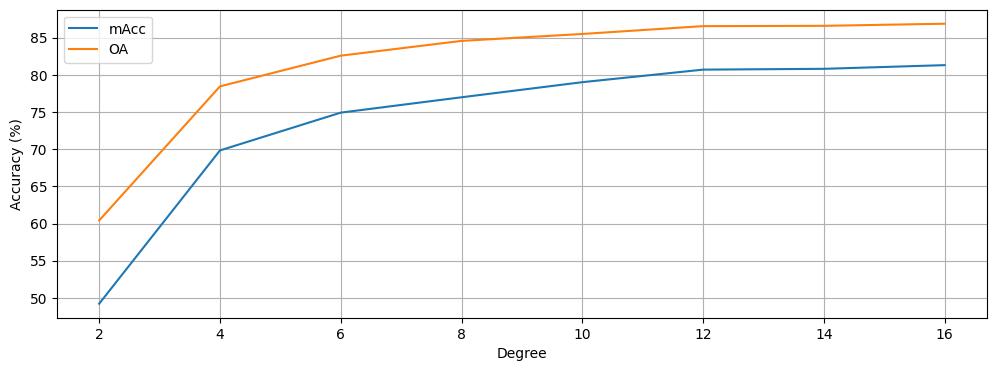

In [12]:
# plot the results
plt.figure(figsize=(12, 4))
plt.plot(results['degree'], results['best_test_acc_avg'], label='mAcc')
plt.plot(results['degree'], results['best_test_acc'], label='OA')
plt.xlabel('Degree')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()
